In [334]:
import os
import numpy as np
import pandas as pd
from langchain_openai import ChatOpenAI
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain_experimental.open_clip import OpenCLIPEmbeddings
from langchain.vectorstores import Chroma
from pydantic import BaseModel, Field, NonNegativeInt
from typing import List
from fastapi.encoders import jsonable_encoder
from diffusers import DiffusionPipeline, AutoPipelineForText2Image
import torch
import PIL


In [577]:
OPEN_API_KEY = "YOUR_API_KEY"
BASE_URL = "https://openai.vocareum.com/v1"
GPT_MODEL = "gpt-4o-mini-2024-07-18"

In [207]:
llm = ChatOpenAI(model=GPT_MODEL, temperature=0, base_url = BASE_URL, api_key = OPEN_API_KEY)

task = "Generate ten diverse real estate listings based on the sample listing below: "
sample_listing = '''
Sample Listing : 

Neighborhood: Green Oaks
Price: $800000
Bedrooms: 3
Bathrooms: 2
House Size: 2000 sqft

Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.

Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy access to public transportation and bike lanes, commuting is a breeze.
'''


In [208]:
class RealEstateListing(BaseModel):
    neighborhood: str = Field(description="The name of the neighborhood where the property is located")
    price: NonNegativeInt = Field(description="Price of the property in USD")
    bedrooms: NonNegativeInt = Field(description="Number of bedrooms in the property")
    bathrooms: NonNegativeInt = Field(description="Number of bathrooms in the property")
    house_size: NonNegativeInt = Field(description="Size of the property in square feet")
    description: str = Field(description="Description of the property")
    neighborhood_description: str = Field(description="Description of the neighborhood")

class ListingsCollection(BaseModel):
    listings: List[RealEstateListing] = Field(description="List of Real Estate Listings")

parser = PydanticOutputParser(pydantic_object=ListingsCollection)

In [209]:
prompt = PromptTemplate(
    template="{task}\n{sample_listing}\n\n{format_instructions}",
    input_variables=["task, sample_listing"],
    partial_variables={"format_instructions": parser.get_format_instructions},
)
query = prompt.format(task=task, sample_listing=sample_listing)
print(query)

Generate ten diverse real estate listings based on the sample listing below: 

Sample Listing : 

Neighborhood: Green Oaks
Price: $800000
Bedrooms: 3
Bathrooms: 2
House Size: 2000 sqft

Description: Welcome to this eco-friendly oasis nestled in the heart of Green Oaks. This charming 3-bedroom, 2-bathroom home boasts energy-efficient features such as solar panels and a well-insulated structure. Natural light floods the living spaces, highlighting the beautiful hardwood floors and eco-conscious finishes. The open-concept kitchen and dining area lead to a spacious backyard with a vegetable garden, perfect for the eco-conscious family. Embrace sustainable living without compromising on style in this Green Oaks gem.

Neighborhood Description: Green Oaks is a close-knit, environmentally-conscious community with access to organic grocery stores, community gardens, and bike paths. Take a stroll through the nearby Green Oaks Park or grab a cup of coffee at the cozy Green Bean Cafe. With easy ac

In [210]:
response = llm(query)

In [211]:
result = parser.parse(response.content)
df = pd.DataFrame(jsonable_encoder(result.listings))
df

neighborhood    price  bedrooms  bathrooms  house_size  \
0    Sunnyvale   650000         4          3        2500   
1     Lakeside  1200000         5          4        3500   
2     Downtown   900000         2          2        1500   
3    Maplewood   750000         3          2        2200   
4      Hilltop   850000         4          3        2800   
5    Riverside   700000         3          2        1800   
6  Cedar Grove   950000         5          4        3200   
7    Westfield   600000         2          1        1200   
8  Forest Hill  1100000         4          3        3000   
9    Oceanview  1300000         3          2        2000   

                                         description  \
0  Discover this spacious 4-bedroom, 3-bathroom f...   
1  This stunning 5-bedroom, 4-bathroom home offer...   
2  Experience urban living in this chic 2-bedroom...   
3  Welcome to this charming 3-bedroom, 2-bathroom...   
4  This beautiful 4-bedroom, 3-bathroom home in H...   
5  This delightful 3-bedroom, 2-bathroom home in ...   
6  This luxurious 5-bedroom, 4-bathroom home in C...   
7  This cozy 2-bedroom, 1-bathroom bungalow in We...   
8  This stunning 4-bedroom, 3-bathroom home in Fo...   
9  This breathtaking 3-bedroom, 2-bathroom beach ...   

                            neighborhood_description  
0  Sunnyvale is a vibrant community known for its...  
1  Lakeside is an upscale neighborhood known for ...  
2  Downtown is a bustling area filled with cultur...  
3  Maplewood is a family-oriented neighborhood kn...  
4  Hilltop is known for its scenic views and tran...  
5  Riverside is a picturesque neighborhood with a...  
6  Cedar Grove is an affluent neighborhood known ...  
7  Westfield is a friendly neighborhood with a sm...  
8  Forest Hill is an upscale neighborhood known f...  
9  Oceanview is a vibrant coastal community known...

In [212]:
df.to_csv('listings.csv',index_label = 'id')

In [3]:
df = pd.read_csv("listings.csv")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo",
    torch_dtype=torch.float16, 
    variant="fp16"
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
prompt = "An 8k high detailed image of a real estate listing with the following property description:\n{}"
images = []

for index, _ in df.iterrows():
    rand_gen = torch.manual_seed(837439186)
    image = pipe(
        prompt=prompt.format(df['description'].iloc[index]), 
        num_inference_steps=3, 
        guidance_scale=1.0, 
        negative_prompt=["overexposed", "underexposed"], 
        generator=rand_gen
    ).images[0]
    images.append(image)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Discover this spacious 4-bedroom, 3-bathroom family home in Sunnyvale. Featuring an open floor plan, modern kitchen with stainless steel appliances, and a cozy fireplace in the living room. The large backyard is perfect for entertaining, complete with a patio and play area for kids.


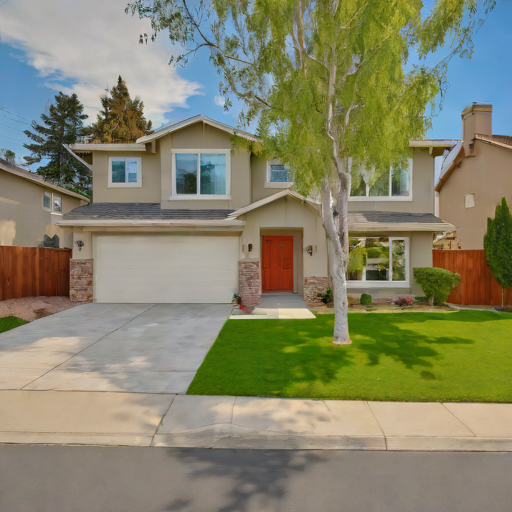




This stunning 5-bedroom, 4-bathroom home offers breathtaking lake views and luxurious finishes. The gourmet kitchen features granite countertops and a large island, while the master suite includes a private balcony. Enjoy outdoor living with a spacious deck and landscaped yard.


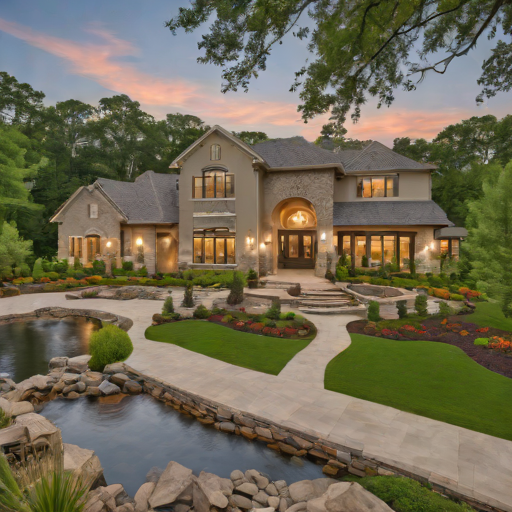




Experience urban living in this chic 2-bedroom, 2-bathroom condo in the heart of Downtown. With floor-to-ceiling windows, modern finishes, and an open layout, this space is perfect for city dwellers. Enjoy amenities like a rooftop pool and fitness center.


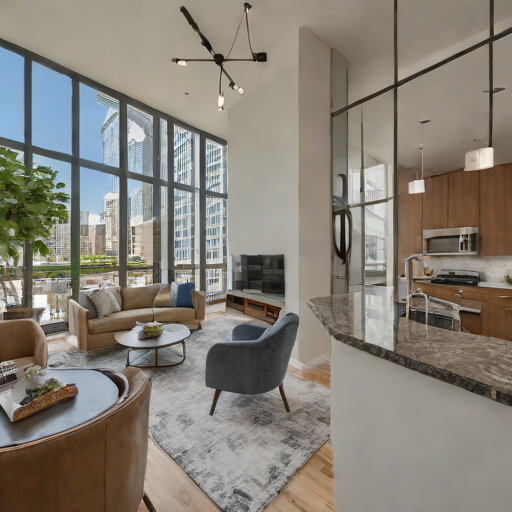




Welcome to this charming 3-bedroom, 2-bathroom home in Maplewood. Featuring a traditional layout with a modern twist, this property includes a renovated kitchen, a cozy den, and a large backyard with mature trees and a fire pit.


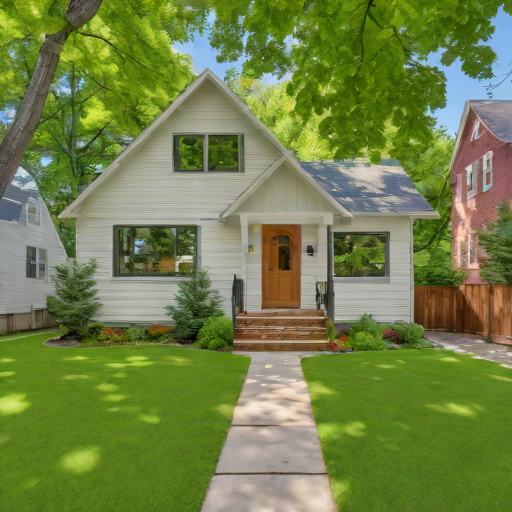




This beautiful 4-bedroom, 3-bathroom home in Hilltop features panoramic views and a spacious layout. The gourmet kitchen opens to a large family room, and the master suite includes a luxurious bathroom. The outdoor space is perfect for entertaining.


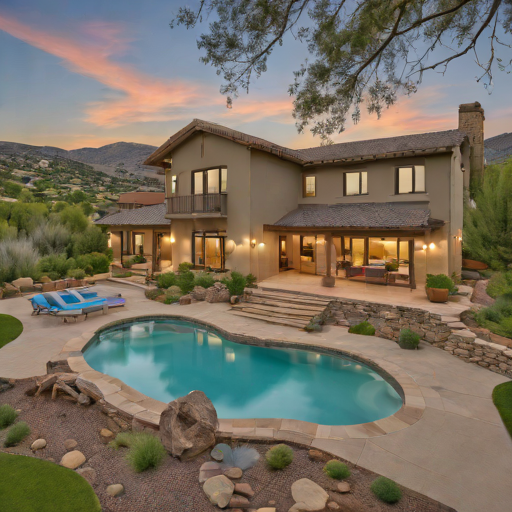

In [10]:
for i in range(5):
    print(df['description'].iloc[i])
    display(images[i])
    print("\n\n")

In [11]:
images_dir = 'images'


if not os.path.exists(images_dir):
    os.makedirs(images_dir)

for i, image in enumerate(images):
    filename = os.path.join(images_dir, str(i) + ".png")
    image.save(filename)

In [479]:
df = pd.read_csv("listings.csv")
image_dir = "images"

ids = [{"id": id} for id in range(len(df.index))]
template ='''

Description: {}
Neighborhood Description: {}
Price($): {}
Bedrooms: {}
Bathrooms: {}
House Size(sqft): {}
'''
image_paths = []
images = []
texts = []

for index, row in df.iterrows():
    image = os.path.join(image_dir, str(index) + ".png")
    images.append(PIL.Image.open(image))
    image_paths.append(image)
    texts.append(template.format(row["description"], row["neighborhood_description"], row["price"], row["bedrooms"], row["bathrooms"], row["house_size"]))

In [478]:
db = Chroma(collection_name="Real_Estate_Listings", embedding_function=OpenCLIPEmbeddings())

/Users/ashishlagad/anaconda/anaconda3/envs/homematch/lib/python3.11/site-packages/open_clip/factory.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.

In [481]:
db.add_texts(texts=texts, metadatas=ids)
db.add_images(uris=image_paths, metadatas=ids)

['0da5ed30-99ae-4ad4-9cef-1da2216f3725',
 '0c8ce937-69b9-43f0-8d10-e23631a5d8a5',
 '70a3953a-0169-4043-a4d3-f22d0f57ba0c',
 'c0b727b0-715a-4d55-a3e6-7dacc413b487',
 '0224e635-46a5-4f3a-82a5-97184426f035',
 '4164efb6-faf1-49c6-b745-7984fa389091',
 '763f21d0-1171-4aa0-aa4e-b12eb420805a',
 '6e4d3130-02f2-4270-a19f-c53162c9ffb3',
 'fd945ea2-5815-4278-a792-87cdb54d524d',
 '7b7fb15d-312b-4e06-9155-20500c5b1d77']

In [540]:
questions = [   
                "How big do you want your house to be?" 
                "What are 3 most important things for you in choosing this property?", 
                "Which amenities would you like?", 
                "Which transportation options are important to you?",
                "How urban do you want your neighborhood to be?",   
            ]
answers = [
    "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
    "A quiet neighborhood, good local schools, and convenient shopping options.",
    "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."
]

In [498]:
def get_preferences(answers: list[str], top_k: int = 3):
    listings = []
    preferences = "".join(answers)
    results = db.similarity_search(preferences, top_k)
    for result in results:
        listings.append(result.metadata["id"])
    return listings



Description: This delightful 3-bedroom, 2-bathroom home in Riverside features an open-concept design with a modern kitchen and a cozy living area. The backyard is perfect for summer barbecues and includes a garden area for planting.
Neighborhood Description: Riverside is a picturesque neighborhood with a strong sense of community. Residents enjoy walking along the river, local parks, and community events. The area is family-friendly with good schools and recreational facilities.
Price($): 700000
Bedrooms: 3
Bathrooms: 2
House Size(sqft): 1800



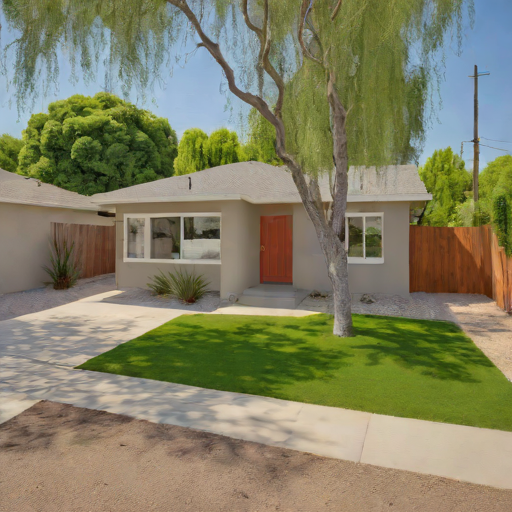

In [499]:
preferred_listings = get_preferences(answers)
print(texts[preferred_listings[0]])
images[preferred_listings[0]]

In [536]:
answers = [
    "Access to public transportation, like buses or a subway station, is important. Having major highways nearby for easy commuting is also a plus."
    "A neighborhood with parks, local shops, and a sense of community would be ideal."
          ]



Description: Experience urban living in this chic 2-bedroom, 2-bathroom condo in the heart of Downtown. With floor-to-ceiling windows, modern finishes, and an open layout, this space is perfect for city dwellers. Enjoy amenities like a rooftop pool and fitness center.
Neighborhood Description: Downtown is a bustling area filled with cultural attractions, restaurants, and nightlife. Residents have easy access to public transportation, making commuting convenient. Enjoy the vibrant city life with art galleries, theaters, and parks nearby.
Price($): 900000
Bedrooms: 2
Bathrooms: 2
House Size(sqft): 1500



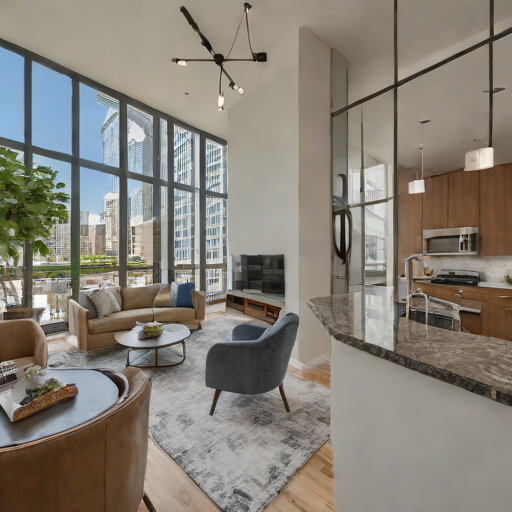

In [538]:
preferred_listings = get_preferences(answers)
print(texts[preferred_listings[0]])
images[preferred_listings[0]]

In [558]:
llm = ChatOpenAI(model=GPT_MODEL, temperature=0, base_url = BASE_URL, api_key = OPEN_API_KEY)
template = '''
For each real estate listing below, create a captivating description tailoring it to resonate with the given buyer’s specific preferences. Make sure to enhance the appeal of the listing without altering factual information.

Real Estate Listings: {}

Buyer's Preferences: {}
'''

In [567]:
def create_custom_prompt(answers):
    text = []
    preferred_listings = get_preferences(answers)
    for listing in preferred_listings:
        text.append(texts[listing])
    return template.format("".join(text), "".join(answers))

In [ ]:
def get_personalized_descriptions(answers):
    prompt = create_custom_prompt(answers)
    response = llm(prompt)
    return response.content

In [561]:
get_personalized_descriptions(answers)

Description 1:
### Riverside Listing Description

Welcome to your dream home in the heart of Riverside! This delightful 3-bedroom, 2-bathroom residence boasts an inviting open-concept design that seamlessly blends a modern kitchen with a cozy living area, perfect for family gatherings and entertaining friends. Imagine summer barbecues in your spacious backyard, complete with a charming garden area just waiting for your green thumb to bring it to life.

Nestled in a picturesque neighborhood, Riverside offers a strong sense of community where you can enjoy leisurely walks along the river, local parks, and vibrant community events. With excellent schools and recreational facilities nearby, this family-friendly area is ideal for those seeking a nurturing environment for their children. Plus, with convenient access to shopping and major highways, you’ll find the perfect balance between suburban tranquility and urban amenities. Don’t miss out on this opportunity to create lasting memories in

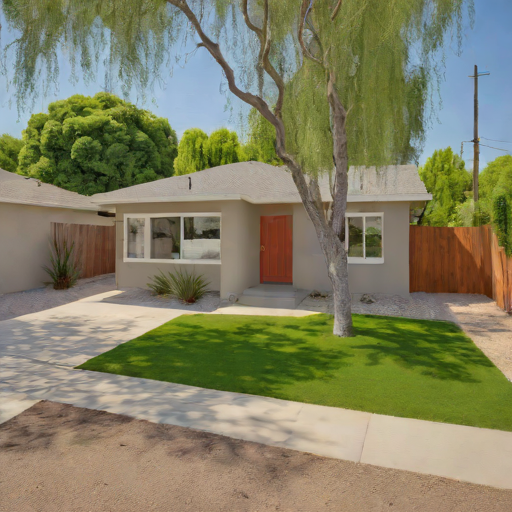

Description 2:


### Maplewood Listing Description

Step into this charming 3-bedroom, 2-bathroom home in the heart of Maplewood, where traditional elegance meets modern convenience. The beautifully renovated kitchen is a chef's delight, flowing effortlessly into a cozy den that invites relaxation and family time. The expansive backyard, adorned with mature trees and a fire pit, is perfect for summer evenings spent under the stars or hosting gatherings with loved ones.

Maplewood is a family-oriented neighborhood that prides itself on its friendly community and top-notch schools, making it an ideal place to raise children. Enjoy the convenience of local parks, playgrounds, and year-round community events, all while being just moments away from shopping and dining options. With a price tag of $750,000, this home offers the perfect blend of comfort, community, and convenience for your family’s next chapter!





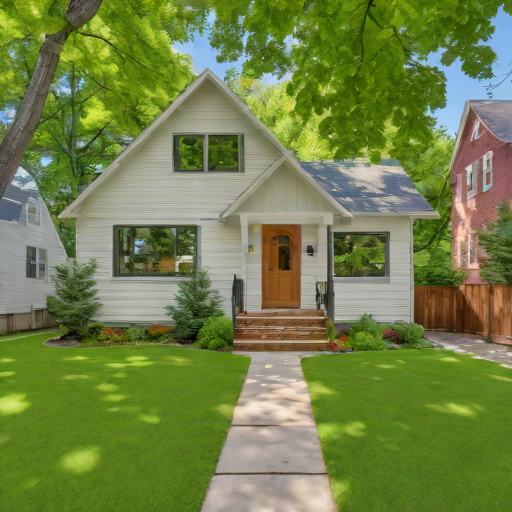

Description 3:


### Hilltop Listing Description

Discover the epitome of luxury living in this stunning 4-bedroom, 3-bathroom home in Hilltop, where breathtaking panoramic views meet spacious elegance. The gourmet kitchen is a culinary enthusiast's dream, opening to a large family room that’s perfect for entertaining or cozy family nights. Retreat to the master suite, featuring a luxurious bathroom that offers a serene escape after a long day.

Hilltop is renowned for its scenic beauty and tranquil atmosphere, providing residents with access to hiking trails, parks, and a close-knit community feel. With excellent schools and shopping centers just a stone's throw away, you’ll enjoy the best of both worlds—suburban peace and urban convenience. Priced at $850,000, this home is a rare find that promises a lifestyle of comfort, elegance, and community connection. Don’t let this opportunity slip away!



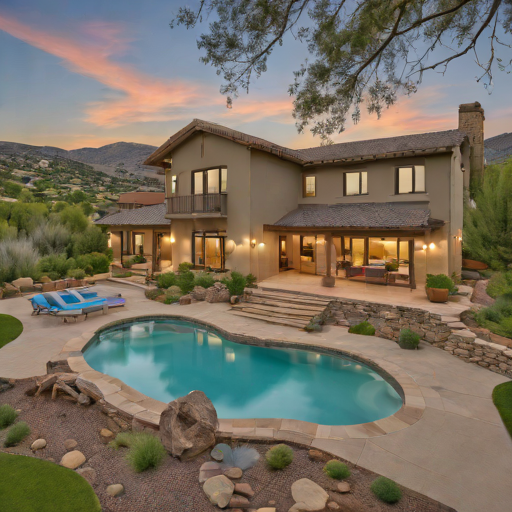

In [576]:
descriptions = response.content.strip().split('---')
for i, desc in enumerate(descriptions):
    print(f"Description {i + 1}:\n{desc}\n")
    display(images[get_preferences(answers)[i]])